# Рекомендация тарифов

## Откроем и изучим файл

**1. Загрузим данные из файла в датафрейм**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy import stats as st
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv', sep=',')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv', sep=',')

**2. Изучим общую информацию о полученном датафрейме**

In [3]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


**3. Построим общую гистограмму для всех числовых столбцов таблицы**

array([[<Axes: title={'center': 'calls'}>,
        <Axes: title={'center': 'minutes'}>],
       [<Axes: title={'center': 'messages'}>,
        <Axes: title={'center': 'mb_used'}>],
       [<Axes: title={'center': 'is_ultra'}>, <Axes: >]], dtype=object)

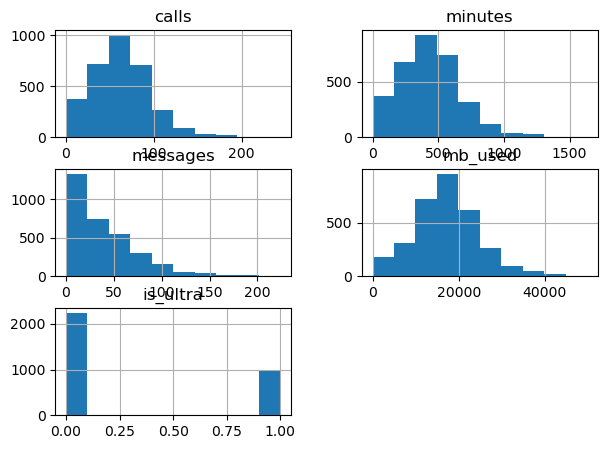

In [30]:
data.hist(figsize=(7,5))

**4. Посмотрим, есть ли в датасете дубликаты, и избавимся от них при их наличии**

In [5]:
data.duplicated().sum()

0

Дубликатов нет, ура!

**5. Проверим, есть ли в датасете пропуски, и избавимся от них при их наличии**

In [6]:
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Все значения заполнены

**6. Изменим тип значений столбца `messages` с float на int**

In [7]:
data['messages']

0       83.0
1       56.0
2       86.0
3       81.0
4        1.0
        ... 
3209    20.0
3210     0.0
3211    70.0
3212    90.0
3213     6.0
Name: messages, Length: 3214, dtype: float64

**Вывод: мы убедились, что в датафрейме нет пропущенных значений и дубликатов. Интересное наблюдение - пользователей тарифа ultra в 2 раза с лишним раза меньше, чем пользователей с другими тарифами. Пожалуй, перед нами стоит задача классификации. За целевой признак берем столбец is_ultra.**

## Разбейте данные на выборки

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов возьмем равными. То есть исходные данные разобьем в соотношении 3:1:1. 60% - обучающая выборка, 20% - валидационная выборка, 20% - тестовая выборка.

In [8]:
#отсеем обучающую выборку и временную тестовую выборку(40% от выборки)
data_train, data_test_temporary = train_test_split(data, test_size=0.4, random_state=12345)
#поделим временную тестовую выборку(40% от выборки) на тестовую и валидационную
data_test, data_valid = train_test_split(data_test_temporary, test_size=0.5, random_state=12345)

Проверим, какие получились выборки по размеру

In [9]:
print('Размер всей выборки:', len(data))
print('Размер обучающей выборки:', len(data_train))
print('Размер тестовой выборки:', len(data_test))
print('Размер валидационной выборки:', len(data_valid))

Размер всей выборки: 3214
Размер обучающей выборки: 1928
Размер тестовой выборки: 643
Размер валидационной выборки: 643


Все верно! С этими выборками можно работать)

Обучающий набор данных сохраним в переменные data_features_train и data_target_train, валидационный набор данных - в data_features_valid и data_target_valid, а тестовый набор данных - в data_features_test и data_target_test.

In [10]:
data_features_train = data_train.drop(['is_ultra'], axis=1)
data_target_train = data_train['is_ultra']
data_features_valid = data_valid.drop(['is_ultra'], axis=1)
data_target_valid = data_valid['is_ultra']
data_features_test = data_test.drop(['is_ultra'], axis=1)
data_target_test = data_test['is_ultra']

**Вывод: мы получили обучающую выборку размером 1928 элементов, тестовую выборку размером 643 элемента и валидационную выборку размером 643 элемента, с которыми будем работать. Также выделили обучающий набор данных, валидационный набор данных и тестовый набор данных**

## Исследуйте модели

Исследуем модели дерево решений, случайный лес и логистическая регрессия. Сохраним лучшие модели. Начнем с модели **дерево решений**

### Модель дерево решений

In [11]:
best_model = 0
best_result = 0

for depth in range(1,51):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(data_features_train, data_target_train)
    valid_predictions = model.predict(data_features_valid)
    accuracy = accuracy_score(data_target_valid, valid_predictions)
    if accuracy > best_result:
        best_model = depth
        best_result = accuracy

print('Лучшая глубина дерева:', best_model)
print('Accuracy наилучшей модели на валидационной выборке:', best_result) 

Лучшая глубина дерева: 7
Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625


Сохраним лучшую модель дерева решений

In [12]:
best_tree_model = DecisionTreeClassifier(random_state=12345, max_depth=7)
best_tree_model.fit(data_features_train, data_target_train)
valid_predictions = best_tree_model.predict(data_features_valid)
accuracy = accuracy_score(data_target_valid, valid_predictions)
print('Глубина дерева:', 7)
print('Accuracy наилучшей модели на валидационной выборке:', accuracy)

Глубина дерева: 7
Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625


In [13]:
best_model = 0
best_result = 0

for depth in range(1,20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(data_features_train, data_target_train)
    valid_predictions = model.predict(data_features_valid)
    accuracy = accuracy_score(data_target_valid, valid_predictions)
    if accuracy > best_result:
        best_model = depth
        best_result = accuracy

print('Лучшая глубина дерева:', best_model)
print('Accuracy наилучшей модели на валидационной выборке:', best_result) 

Лучшая глубина дерева: 7
Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625


Далее исследуем модель **случайный лес**

### Модель случайный лес

Для этой модели будем менять гиперпарметры и исследуем результат. Изначально будем менять гиперпараметр n_estimators, но не будем его брать в особый расчет для решения задачи "влияние гиперпараметров на результат"

In [14]:
best_model = None
best_result = 0
for est in range(1, 51):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(data_features_train, data_target_train) 
    result = model.score(data_features_valid, data_target_valid) 
    if result > best_result:
        best_model =  est
        best_result = result
        
print('Количество деревьев:', best_model)
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Количество деревьев: 48
Accuracy наилучшей модели на валидационной выборке: 0.7962674961119751


Изменим параметр max_features. По умолчанию он max_features=n_features, считается, что для задачи классификации лучше всего подходит значение sqrt. Однако проверим еще и значение 1.  

In [15]:
best_model = None
best_result = 0
for est in range(1, 51):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_features='sqrt') 
    model.fit(data_features_train, data_target_train) 
    result = model.score(data_features_valid, data_target_valid) 
    if result > best_result:
        best_model =  est
        best_result = result
        
print('Количество деревьев:', best_model)
print("Accuracy наилучшей модели на валидационной выборке при max_features='sqrt':", best_result)

Количество деревьев: 48
Accuracy наилучшей модели на валидационной выборке при max_features='sqrt': 0.7962674961119751


In [16]:
best_model = None
best_result = 0
for est in range(1, 51):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_features=1) 
    model.fit(data_features_train, data_target_train) 
    result = model.score(data_features_valid, data_target_valid) 
    if result > best_result:
        best_model =  est
        best_result = result
        
print('Количество деревьев:', best_model)
print("Accuracy наилучшей модели на валидационной выборке при max_features=1:", best_result)

Количество деревьев: 18
Accuracy наилучшей модели на валидационной выборке при max_features=1: 0.7916018662519441


Сохраним лучшую модель случайного леса. Это такая модель, что количество деревьев 24, а criterion='entropy'

In [19]:
best_forest_model = RandomForestClassifier(random_state=12345, n_estimators=24, criterion='entropy') 
best_forest_model.fit(data_features_train, data_target_train)
valid_predictions = best_forest_model.predict(data_features_valid)
accuracy = accuracy_score(data_target_valid, valid_predictions)
print('Количество деревьев:', 24)
print("Accuracy наилучшей модели на валидационной выборке:", accuracy)

Количество деревьев: 24
Accuracy наилучшей модели на валидационной выборке: 0.7978227060653188


Далее исследуем модель **логистическая регрессия**

### Модель логистическая регрессия

In [20]:
model_logistic_regression = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_logistic_regression.fit(data_features_train, data_target_train)
valid_predictions = model_logistic_regression.predict(data_features_valid)
accuracy = accuracy_score(data_target_valid, valid_predictions)

print("Accuracy наилучшей модели на валидационной выборке:", accuracy)

Accuracy наилучшей модели на валидационной выборке: 0.6842923794712286


**Вывод: при исследовании моделей решающего дерева, случайного леса и логистичесакой регрессии было выявлено, что лучший результат по метрике Accuracy показывает модель решающего дерева. Немногим отстает и модель случайного леса. Хуже всего точность у логистической регрессии.**
- Accuracy дерева решений = 0.7993779160186625 при глубине дерева 7.
- Accuracy случайного леса = 0.7978227060653188 количестве деревьев 24 и гиперпараметре criterion='entropy'(гиперпараметры со значениями max_features=1 и bootstrap=False только ухудшают результат).
- Accuracy логистической регрессии = 0.6889580093312597.

**Однако стоит проверить результаты на тестовой выборке**

## Проверим модели на тестовой выборке

In [21]:
test_predictions = best_tree_model.predict(data_features_test)
accuracy = accuracy_score(data_target_test, test_predictions)
print('Точность модели дерева решений на тестовой выборке:', accuracy)

Точность модели дерева решений на тестовой выборке: 0.7822706065318819


In [22]:
test_predictions = best_forest_model.predict(data_features_test)
accuracy = accuracy_score(data_target_test, test_predictions)
print('Точность модели случайного леса на тестовой выборке:', accuracy)

Точность модели случайного леса на тестовой выборке: 0.7853810264385692


In [23]:
test_predictions = model_logistic_regression.predict(data_features_test)
accuracy = accuracy_score(data_target_test, test_predictions)
print('Точность модели логистической регрессии на тестовой выборке:', accuracy)

Точность модели логистической регрессии на тестовой выборке: 0.7107309486780715


**Вывод: при проверке моделей на тестовой выборке было выяснено, что точность модели дерева решений на тестовой выборке: 0.7822706065318819, точность модели случайного леса на тестовой выборке: 0.7853810264385692, а точность модели логистической регрессии на тестовой выборке: 0.7107309486780715. Исходя из этого, можно сделать вывод, что лучше всего на "почти реальной" задаче себя показывает модель случайного леса. Целесообразней в дальнейшем использовать именно ее**

## Вывод

Перед нами была поставлена задача: построить модель для задачи классификации, которая выберет подходящий тариф. И требовалось, чтобы эта модель обладала максимально большим значением accuracy. 

В ходе работы мы изучили предлагаемый файл. Разделили исходные данные на обучающую, валидационную и тестовую выборки. При этом мы получили обучающую выборку размером 1928 элементов, тестовую выборку размером 643 элемента и валидационную выборку размером 643 элемента. Также выделили обучающий набор данных, валидационный набор данных и тестовый набор данных.

Исследовали качество разных моделей, меняя гиперпараметры.
При исследовании моделей решающего дерева, случайного леса и логистичесакой регрессии было выявлено, что лучший результат по метрике Accuracy показывает модель решающего дерева. Немногим отстает и модель случайного леса. Хуже всего точность у логистической регрессии.
- Accuracy дерева решений = 0.7993779160186625 при глубине дерева 7.
- Accuracy случайного леса = 0.7978227060653188 количестве деревьев 24 и гиперпараметре criterion='entropy'(гиперпараметры со значениями max_features=1 и bootstrap=False только ухудшают результат).
- Accuracy логистической регрессии = 0.6889580093312597.

Проверили качество модели на тестовой выборке и выяснили, что точность модели дерева решений на тестовой выборке: 0.7822706065318819, точность модели случайного леса на тестовой выборке: 0.7853810264385692, а точность модели логистической регрессии на тестовой выборке: 0.7107309486780715. Исходя из этого, можно сделать вывод, что лучше всего на "почти реальной" задаче себя показывает модель случайного леса.

**Рекомендации: для решения задачи выбора подходящего тарифа обращайтесь к модели случайного леса. Ее метрика Accuracy выше всех, и, что важно, превышает 0.75.**
